# Transfer learning

In [2]:
#!pip install tqdm

In [3]:
# Descargar el dataset

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2021-12-19 07:44:23--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   167MB/s    in 0.4s    

2021-12-19 07:44:24 (167 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### Preprocesado de datos

In [4]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline


In [5]:
# Descomprimir el dataset de perros vs gatos
dataset_path = './cats_and_dogs_filtered.zip' # Ruta
zip_object = zipfile.ZipFile(file = dataset_path, mode = 'r') # Extraer las imagenes
zip_object.extractall('./') 
zip_object.close()

In [6]:
# Configurar las rutas al dataset
dataset_path_new = './cats_and_dogs_filtered/'
train_dir = os.path.join(dataset_path_new, 'train')
validation_dir = os.path.join(dataset_path_new, 'validation')

### Construir el Modelo

#### Cargar un modelo pre entrenado (MobileNetV2)

In [7]:
IMG_SHAPE = (128, 128, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights= 'imagenet')

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [9]:
# Congelar el modelo base
base_model.trainable = False

In [10]:
# Definir la cabecera personalizada para nuestra red neuronal
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d')>

In [12]:
dropout_layer = tf.keras.layers.Dropout(0.2)(global_average_layer)

In [13]:
prediction_layer = tf.keras.layers.Dense(units = 1, activation ='sigmoid')(dropout_layer)

#### Definir el modelo

In [14]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

#### Compilar el modelo

In [16]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


#### Crear generadores de datos

In [17]:
data_gen_train = ImageDataGenerator(rescale = 1/255.)
data_gen_valid = ImageDataGenerator(rescale = 1/255.)

In [18]:
train_generator = data_gen_train.flow_from_directory(train_dir,
                                                     target_size = (128, 128),
                                                     batch_size = 128,
                                                     class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [24]:
valid_generator = data_gen_valid.flow_from_directory(validation_dir,
                                                     target_size = (128, 128),
                                                     batch_size = 128,
                                                     class_mode = 'binary')

Found 1000 images belonging to 2 classes.


In [35]:
class myCallback(tf.keras.callbacks.Callback):
       
        def on_epoch_end(self, epoch, logs = {}):
            if(logs.get('accuracy')>0.999):
                print("\nReached 100% accuracy so cancelling training!")
                self.model.stop_training = True
callbacks = myCallback()

#### Entrenar el modelo

In [27]:
model.fit(train_generator, epochs = 100, validation_data= valid_generator, callbacks= callbacks)

Epoch 1/100
16/16 [==============================] - 10s 625ms/step - loss: 0.1757 - accuracy: 0.9420 - val_loss: 0.1634 - val_accuracy: 0.9440
Epoch 2/100
16/16 [==============================] - 10s 635ms/step - loss: 0.1683 - accuracy: 0.9450 - val_loss: 0.1573 - val_accuracy: 0.9440
Epoch 3/100
16/16 [==============================] - 10s 627ms/step - loss: 0.1628 - accuracy: 0.9465 - val_loss: 0.1517 - val_accuracy: 0.9480
Epoch 4/100
16/16 [==============================] - 10s 624ms/step - loss: 0.1545 - accuracy: 0.9465 - val_loss: 0.1470 - val_accuracy: 0.9500
Epoch 5/100
16/16 [==============================] - 10s 623ms/step - loss: 0.1495 - accuracy: 0.9480 - val_loss: 0.1426 - val_accuracy: 0.9500
Epoch 6/100
16/16 [==============================] - 10s 624ms/step - loss: 0.1462 - accuracy: 0.9530 - val_loss: 0.1387 - val_accuracy: 0.9490
Epoch 7/100
16/16 [==============================] - 10s 615ms/step - loss: 0.1397 - accuracy: 0.9510 - val_loss: 0.1354 - val_accuracy:

In [30]:
# Evaluar el modelo de aprendizaje por transferencia
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print('Accuracy after transfer learning: {}'.format(valid_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Accuracy after transfer learning: 0.9660000205039978


#### Finetuning


In [31]:
# Descongelar unas cuantas capas superiores del modelo
base_model.trainable = True
print('Number of layers in the base model: {}'.format(len(base_model.layers)))

Number of layers in the base model: 154


In [32]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [33]:
# Compilar el modelo para la puesta a punto

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [36]:
history = model.fit(train_generator,
          epochs = 100,
          validation_data= valid_generator, 
          callbacks= callbacks)

Epoch 1/100
16/16 [==============================] - 70s 4s/step - loss: 0.1439 - accuracy: 0.9390 - val_loss: 0.1155 - val_accuracy: 0.9550
Epoch 2/100
16/16 [==============================] - 11s 671ms/step - loss: 0.0200 - accuracy: 0.9970 - val_loss: 0.0855 - val_accuracy: 0.9690
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9995
Reached 100% accuracy so cancelling training!
16/16 [==============================] - 11s 704ms/step - loss: 0.0093 - accuracy: 0.9995 - val_loss: 0.0824 - val_accuracy: 0.9730


Text(0.5, 1.0, 'Training and validation loss')

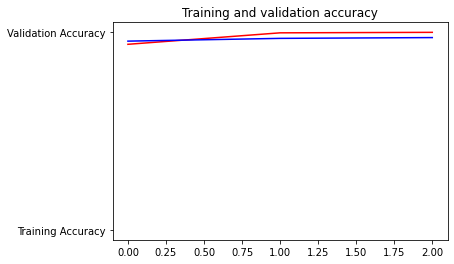

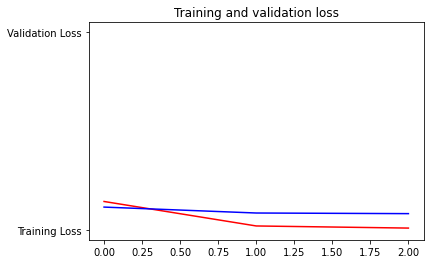

In [38]:
import matplotlib.image  as mpimg


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

#### Evaluar el modelo recalibrado

In [39]:
valid_loss, valid_accuracy = model.evaluate_generator(valid_generator)
print('Validation accuracy after fine tunning: {}'.format(valid_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Validation accuracy after fine tunning: 0.9729999899864197
